In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
maindatapath = "../OSC-measuresments/"

oscpaths = [maindatapath + osc +"/" for osc in  os.listdir(maindatapath) if osc[-4:]!=".jpg"] # the paths to the folders of the samples

cellpaths = lambda osc : [ oscpaths[osc] + cell + "/" for cell in os.listdir(oscpaths[osc]) ]

measurementpaths = lambda osc, cell : [cellpaths(osc)[cell] + measurement for measurement in os.listdir(cellpaths(osc)[cell])]

measurement = lambda osc,cell,mm : np.loadtxt(measurementpaths(osc,cell)[mm], skiprows=1).T

print(oscpaths)

['../OSC-measuresments/OSC1/', '../OSC-measuresments/OSC2/', '../OSC-measuresments/OSC3/', '../OSC-measuresments/OSC4/', '../OSC-measuresments/OSC5/', '../OSC-measuresments/PatrickOSC/', '../OSC-measuresments/ReraSC/']


In [7]:
#measurementrelevant = lambda osc, cell, mm : np.where(measurement(osc,cell,mm)*np.array([[1],[-1]])>0,measurement(osc,cell,mm),0)
measurementrelevant = lambda osc, cell, mm : np.where(measurement(osc,cell,mm)*np.array([[1],[-1]])>0,measurement(osc,cell,mm),0)
measurementrelevant(0,0,0).shape

(2, 201)

In [36]:
def interpolate(mat, witherrors=False):
    x1,x2 = mat[0]
    y1,y2 = mat[1]
    x0 = (y1*x2-y2*x1)/(y1-y2)
    return x0


def find_zeros(mm):
    V = mm[0]
    I = mm[1]
    iscindeces = [np.where(V<0)[0][-1],np.where(V>0)[0][0]]
    vocindeces = [np.where(I<0)[0][-1],np.where(I>0)[0][0]]
    isc = interpolate(np.array([[0,1],[1,0]])@mm[:,iscindeces]) # the matrix mult is to swap the voltage and current
    voc = interpolate(mm[:,vocindeces])
    return isc, voc, iscindeces, vocindeces

def power_curve(mmr):
    V,I = mmr
    P = V*np.abs(I)
    return P

measurement1 = measurement(0,0,1)

#measurement1[:,find_zeros(measurement1)[1]]

find_zeros(measurement1)

(-8.931019768108607e-05, 0.42458230262617314, [40, 41], [124, 125])

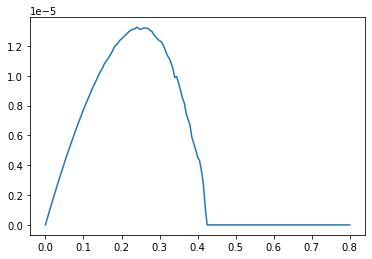

In [37]:
mr1 = measurementrelevant(0,0,1)
power1 = power_curve(mr1)
plt.plot(mr1[0],power1)

array([[3, 4],
       [1, 2]])